In [140]:
import pandas as pd
import numpy as np
import tkinter
import matplotlib.pyplot as plt
import scipy.stats as stats
import matplotlib
#matplotlib inline
#%matplotlib notebook
import seaborn as sns
from random import randint
pd.set_option('display.max_columns', None)

In [165]:
movies_df=pd.read_csv('final_movie_data_df.csv',encoding='Latin')

In [166]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'prof_loss', 'pcnt_prof_loss', 'release_date_upd'],
      dtype='object')

In [167]:
def fix_release_dates(date_string,year,title):
    #function to fix the release dates
    try:
        if pd.isnull(date_string) | ('NoReleaseDates' in str(date_string)):
            #could not find release dates for around 400 of the movies
            #will default those to 15the of a random month of the release year
            def_date='15-'+str(randint(1,12))+'-'+str(int(year))
            #print('default date:',def_date)
            conv_date=pd.to_datetime(def_date)
        elif '0 ' in str(date_string)[0:2]:
            #some release dates have the date as '0 January 2010'
            #converting those to 01 January 2010
            def_date='01 '+date_string[2:]
            conv_date=pd.to_datetime(def_date)
        else:
            conv_date = pd.to_datetime(date_string,errors='coerce')
        
        if pd.isnull(conv_date):
            print(title,' ',date_string)
            return('error')
        else:
            return(conv_date)
        #return(date_string)
    except ValueError:
        return('ValueError '+date_string)
    except AssertionError:
        return('AssertionError'+date_string)


#-------------------------------------------------------------------
def build_rel_month_dict(date):
    rel_month = {'Jan':0,'Feb':0,'Mar':0,'Apr':0,'May':0,'Jun':0,'Jul':0,'Aug':0,'Sep':0,'Oct':0,'Nov':0,'Dec':0}
    if date.month==1:
        rel_month['Jan']=1
    elif date.month==2:
        rel_month['Feb']=1
    elif date.month==3:
        rel_month['Mar']=1
    elif date.month==4:
        rel_month['Apr']=1
    elif date.month==5:
        rel_month['May']=1
    elif date.month==6:
        rel_month['Jun']=1
    elif date.month==7:
        rel_month['Jul']=1
    elif date.month==8:
        rel_month['Aug']=1
    elif date.month==9:
        rel_month['Sep']=1
    elif date.month==10:
        rel_month['Oct']=1
    elif date.month==11:
        rel_month['Nov']=1
    elif date.month==12:
        rel_month['Dec']=1
    
    return rel_month


In [168]:
movies_df['release_date_upd']=movies_df[['release_date','year','title']].apply(lambda x:fix_release_dates(x['release_date'],x['year'],x['title']),axis=1)

In [169]:
#movies_df.set_value(54,'release_date','13-10-1995')
#movies_df.set_value(1014,'release_date','31-5-2002')
#movies_df.loc[1014]

In [170]:
movies_df=pd.concat([movies_df,movies_df['release_date_upd'].apply(lambda x:build_rel_month_dict(x)).apply(pd.Series)],axis=1)

In [171]:
movies_df.columns

Index(['imdbId', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
       'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
       'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War',
       'Western', 'actor1_gender', 'actor1_name', 'actor1_score',
       'actor2_gender', 'actor2_name', 'actor2_score', 'actor3_gender',
       'actor3_name', 'actor3_score', 'actor4_gender', 'actor4_name',
       'actor4_score', 'director', 'director_score', 'found', 'genres', 'kind',
       'movieBudget', 'movieId', 'movie_4th_wknd_bo', 'movie_details', 'plot',
       'release_date', 'studio', 'title', 'tmdbId', 'year', 'year_orig',
       'prof_loss', 'pcnt_prof_loss', 'release_date_upd', 'Apr', 'Aug', 'Dec',
       'Feb', 'Jan', 'Jul', 'Jun', 'Mar', 'May', 'Nov', 'Oct', 'Sep'],
      dtype='object')

In [172]:
movies_df[np.isnan(pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce'))]['title']

Series([], Name: title, dtype: object)

In [173]:
movies_df['movie_4th_wknd_bo']=pd.to_numeric(movies_df['movie_4th_wknd_bo'],errors='coerce')

In [174]:
movies_df['prof_loss']=movies_df['movie_4th_wknd_bo']-movies_df['movieBudget']


In [175]:
movies_df['pcnt_prof_loss']=(movies_df['movie_4th_wknd_bo']-movies_df['movieBudget'])/(movies_df['movieBudget'])


In [176]:
movies_df[['actor1_score','actor2_score','actor3_score','actor4_score','director_score','prof_loss','pcnt_prof_loss']].describe()

,actor1_score,actor2_score,actor3_score,actor4_score,director_score,prof_loss,pcnt_prof_loss
count,1011.000000,1011.000000,1011.000000,1010.000000,2587.000000,2.587000e+03,2587.000000
mean,33.454006,34.301682,37.178042,38.572277,13.606881,-1.006517e+06,1.885869
std,22.111343,27.591845,32.791329,35.626952,13.440902,3.273861e+07,51.065589
min,1.000000,1.000000,1.000000,1.000000,0.000000,-1.535949e+08,-0.999928
25%,19.000000,16.000000,16.000000,15.000000,5.000000,-1.467060e+07,-0.562242
50%,29.000000,27.000000,29.000000,30.000000,10.000000,-2.239484e+06,-0.143890
75%,43.000000,44.000000,48.500000,52.000000,18.000000,1.091140e+07,0.527570
max,220.000000,206.000000,363.000000,286.000000,107.000000,2.566285e+08,2210.449533


In [177]:
movies_df.sort_values(by=['prof_loss'],ascending=False)[0:10][['title','prof_loss']]

,title,prof_loss
1719,"Dark Knight, The (2008)",256628497.0
2284,Deadpool (2016),253484061.0
2157,Despicable Me 2 (2013),230812720.0
2308,Minions (2015),213578650.0
1884,Avatar (2009),193846514.0
1004,Spider-Man (2002),187334752.0
2146,Iron Man 3 (2013),167407116.0
1312,Shrek 2 (2004),164523202.0
240,Raiders of the Lost Ark (Indiana Jones and the...,163718672.0
1391,Meet the Fockers (2004),151110125.0


In [178]:
movies_df.sort_values(by=['prof_loss'],ascending=False)[-10:][['title','prof_loss']]

,title,prof_loss
2281,Warcraft (2016),-114201345.0
2294,Pan (2015),-118139059.0
1371,Alexander (2004),-121350487.0
1688,"Golden Compass, The (2007)",-128724672.0
1982,Mars Needs Moms (2011),-129629390.0
2161,"Lone Ranger, The (2013)",-129678570.0
629,"13th Warrior, The (1999)",-133186925.0
2246,Jupiter Ascending (2015),-136337704.0
2194,47 Ronin (2013),-137399780.0
2077,Battleship (2012),-153594855.0


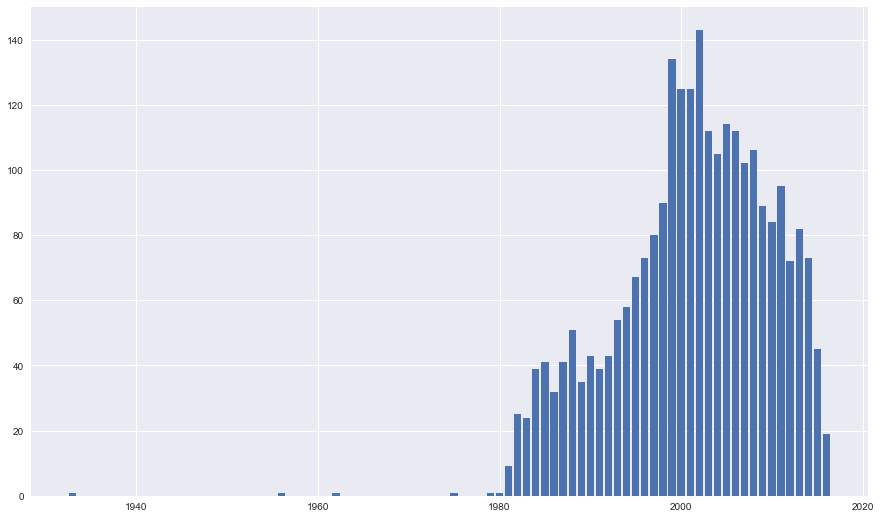

In [197]:
data=movies_df[['year','imdbId']].groupby('year').size()
f,ax=plt.subplots(figsize=(15,9))
plt.bar(data.keys(),data.values)
plt.show()


In [199]:
movies_df[['actor1_name','imdbId']].groupby('actor1_name').size().sort_values()

actor1_name
50 Cent                   1
Lance Bass                1
Larenz Tate               1
Larry David               1
Laura Regan               1
Lauren Bittner            1
Lauren Hutton             1
Lea Thompson              1
Leelee Sobieski           1
Leigh Whannell            1
Lena Dunham               1
Leo Fitzpatrick           1
Leon                      1
Leslie Nielsen            1
Levi Stubbs               1
Liev Schreiber            1
Lillian Adams             1
Linda Hunt                1
Lisa Boyle                1
Lizzy Caplan              1
Lochlyn Munro             1
Logan Lerman              1
Loren Dean                1
Lou Diamond Phillips      1
Kyra Sedgwick             1
Kristen Stewart           1
Kristen Connolly          1
Kristanna Loken           1
Keith David               1
Keith Gordon              1
                         ..
Will Smith               12
Jim Carrey               12
Ben Affleck              12
Keanu Reeves             12
Leonardo

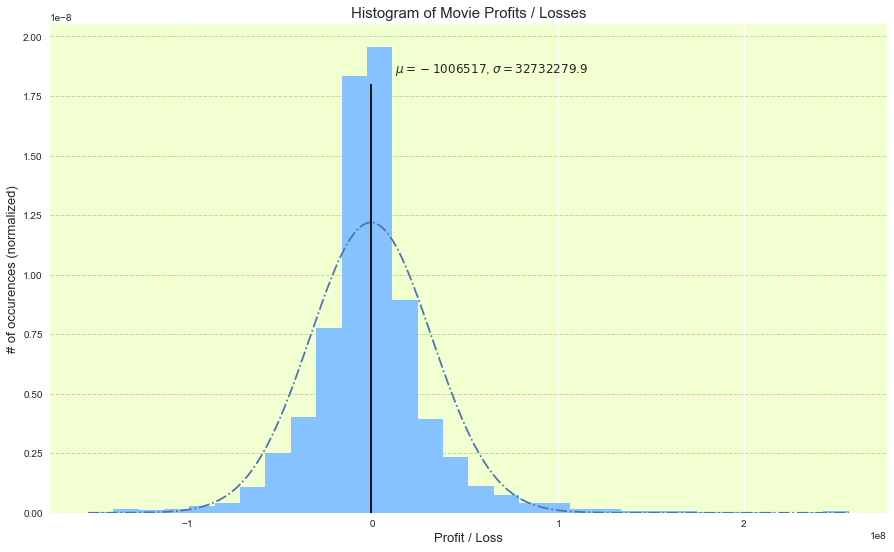

In [52]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=sorted(movies_df['prof_loss'])
mean=np.mean(data)

std=np.std(data)
fit = stats.norm.pdf(data, np.mean(data), np.std(data))  #this is a fitting indeed

ax.set_title(r'Histogram of Movie Profits / Losses',fontsize=15)
ax.set_xlabel('Profit / Loss',fontsize=13)
ax.set_ylabel('# of occurences (normalized)',fontsize=13)
xmin,xmax=ax.get_xbound()
ymin,ymax=ax.get_ybound()
ax.get_xbound

plt.text(0.12e8,1.85e-8,'$\mu=%.0f$, $\sigma=%.1f$' %(mean,std))

plt.plot(data,fit,'-.')
plt.hist(data,bins=30,normed=True,color='#85C2FF')
plt.vlines(mean,ymin,1.8e-8)
plt.show()

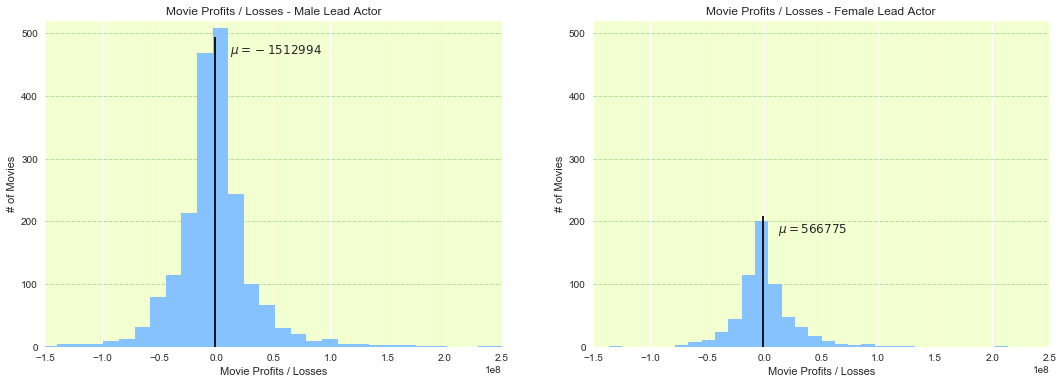

In [61]:
f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=520
btm=0.0
lft=-1.5e8
rght=2.5e8



m_data=movies_df[movies_df['actor1_gender']=='Male']['prof_loss']
m_mean=np.mean(m_data)

ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax0.set_title(r'Movie Profits / Losses - Male Lead Actor',fontsize=12)
ax0.set_xlabel('Movie Profits / Losses')
ax0.set_ylabel('# of Movies')
ax0.set_xlim(left=lft,right=rght,auto=False)
ax0.set_ylim(bottom=btm,top=top,auto=False)
ax0.text(0.12e8,top*0.9,'$\mu=%.0f$' %(m_mean))

ax0.hist(m_data,bins=30,color='#85C2FF')
ax0.vlines(mean,0,top*0.95)



f_data=movies_df[movies_df['actor1_gender']=='Female']['prof_loss']
f_mean=np.mean(f_data)

ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)
ax1.set_title(r'Movie Profits / Losses - Female Lead Actor',fontsize=12)
ax1.set_xlabel('Movie Profits / Losses')
ax1.set_ylabel('# of Movies')
ax1.set_xlim(left=lft,right=rght,auto=False)
ax1.set_ylim(bottom=btm,top=top,auto=False)
ax1.text(0.12e8,top*0.35,'$\mu=%.0f$' %(f_mean))


#ax1.plot(f_data,fit,'-.')
ax1.hist(f_data,bins=30,color='#85C2FF')
ax1.vlines(mean,0,top*0.4)


plt.show()

In [70]:
movies_df['pcnt_prof_loss'].describe()

count    2587.000000
mean        1.885869
std        51.065589
min        -0.999928
25%        -0.562242
50%        -0.143890
75%         0.527570
max      2210.449533
Name: pcnt_prof_loss, dtype: float64

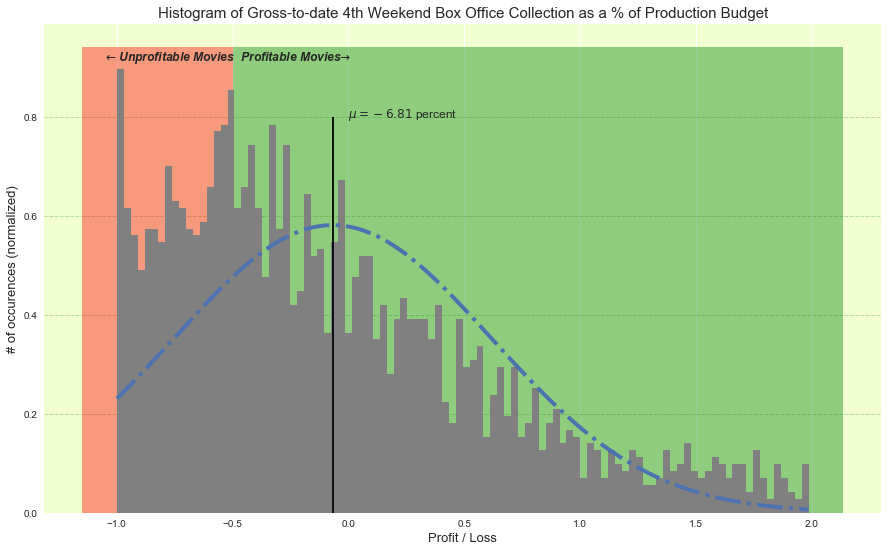

In [142]:
f,ax=plt.subplots(figsize=(15,9))
ax.set_facecolor(color='#f1ffd1')
ax.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

#include all movies whose 4th weekend box office collection is less than
#200% of the production budget, the rest are considered outliers
data=sorted(movies_df[movies_df['pcnt_prof_loss']<2]['pcnt_prof_loss'])
mean=np.mean(data)

fit = stats.norm.pdf(data, np.mean(data), np.std(data))  #this is a fitting indeed

ax.set_title(r'Histogram of Gross-to-date 4th Weekend Box Office Collection as a % of Production Budget',fontsize=15)
ax.set_xlabel('Profit / Loss',fontsize=13)
ax.set_ylabel('# of occurences (normalized)',fontsize=13)


plt.text(0,0.8,'$\mu=%.2f$ percent' %(mean*100))

plt.plot(data,fit,'-.',linewidth=4)
plt.hist(data,bins=100,normed=True,color='grey')
plt.vlines(mean,ymin,0.8)
xmin,xmax=ax.get_xlim()
ymin,ymax=ax.get_ylim()

ax.fill_between([xmin,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
plt.text(-1.05,.97*ymax,'$\u2190$ Unprofitable Movies',horizontalalignment='left',style='italic',weight='bold')
plt.text(-0.48,.97*ymax,' Profitable Movies$\u2192$',horizontalalignment='left',style='italic',weight='bold')

ax.fill_between([-0.5,xmax], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)
plt.show()

In [143]:
temp_df=movies_df[movies_df['pcnt_prof_loss']<2]

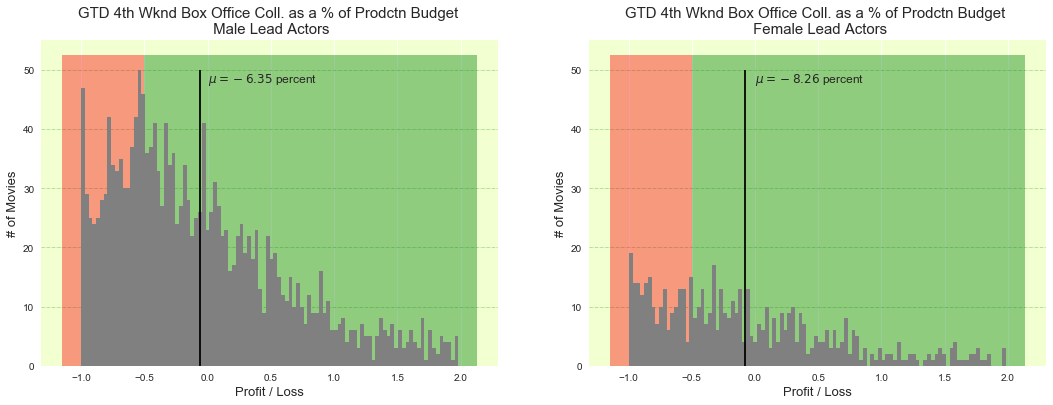

In [159]:
f,ax=plt.subplots(nrows=1, ncols=2,figsize=(18,6))
ax0, ax1 = ax.flatten()
top=55
btm=0.0
lft=-1.2
rght=2.2
#For Male Lead Actor
ax0.set_facecolor(color='#f1ffd1')
ax0.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Male']['pcnt_prof_loss']
mean=np.mean(data)

ax0.hist(data,bins=100,color='grey')

ax0.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Male Lead Actors',fontsize=15)
ax0.set_xlabel('Profit / Loss',fontsize=13)
ax0.set_ylabel('# of Movies',fontsize=13)
ax0.text(0,48,'$\mu=%.2f$ percent' %(mean*100))
ax0.vlines(mean,ymin,50)
xmin,xmax=ax0.get_xlim()
ymin,ymax=ax0.get_ylim()

ax0.fill_between([xmin,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
ax0.fill_between([-0.5,xmax], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)

#For Female Lead Actor
ax1.set_facecolor(color='#f1ffd1')
ax1.grid(False, 'major','y', ls='-.', lw=.5, c='g', alpha=.5)

data=temp_df[temp_df.actor1_gender=='Female']['pcnt_prof_loss']
mean=np.mean(data)

ax1.hist(data,bins=100,color='grey')

ax1.set_title('GTD 4th Wknd Box Office Coll. as a % of Prodctn Budget \n Female Lead Actors',fontsize=15)
ax1.set_xlabel('Profit / Loss',fontsize=13)
ax1.set_ylabel('# of Movies',fontsize=13)
ax1.text(0,48,'$\mu=%.2f$ percent' %(mean*100))
ax1.vlines(mean,ymin,50)
xmin,xmax=ax1.get_xlim()
ymin,ymax=ax1.get_ylim()

ax1.fill_between([xmin,-0.5], ymin,ymax, facecolor='red', alpha = .4, interpolate=True)
ax1.fill_between([-0.5,xmax], ymin,ymax, facecolor='green', alpha = .4, interpolate=True)

plt.show()

In [62]:
#excluding 2 directors who are outliers
(movies_df['director_score']>100).sum()

1

In [67]:
#excluding 2 directors who are outliers
temp_df=movies_df[movies_df['director_score']<100]

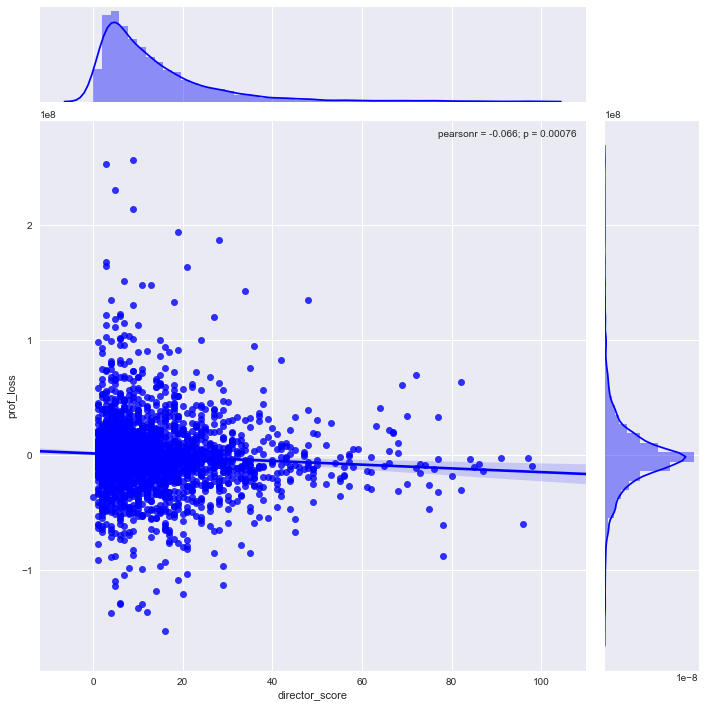

In [68]:
sns.jointplot(temp_df['director_score'], temp_df['prof_loss'],  kind="reg", color="b", size=10)
plt.show()
#plt.tight_layout()

In [624]:
movies_df['actor1_score'].describe()

count    1011.000000
mean       33.454006
std        22.111343
min         1.000000
25%        19.000000
50%        29.000000
75%        43.000000
max       220.000000
Name: actor1_score, dtype: float64

In [625]:
#excluding 13 actor1 who are outliers
(movies_df['actor1_score']>100).sum()

11

In [626]:
#excluding 13 actor1 who are outliers
temp_df=movies_df[movies_df['actor1_score']<100]

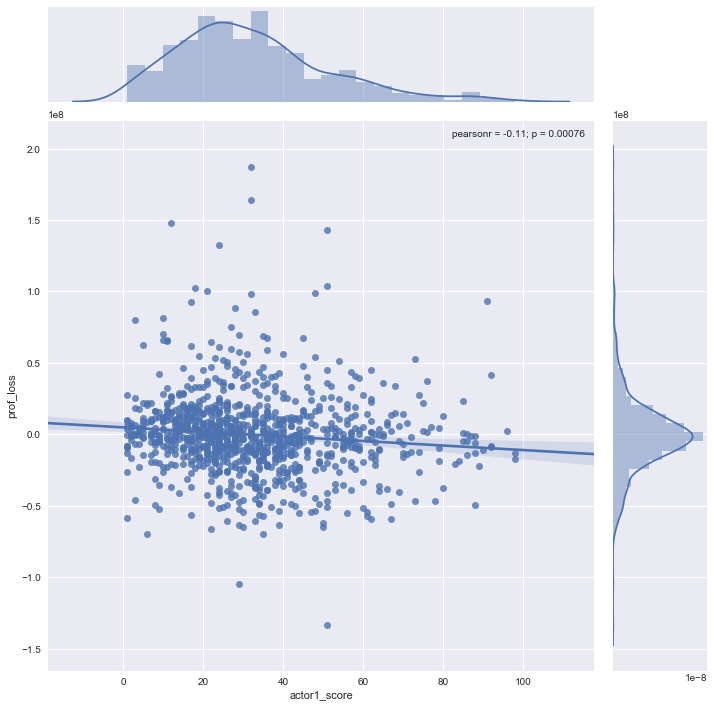

In [627]:
sns.jointplot(temp_df['actor1_score'], temp_df['prof_loss'],  kind="reg", color="b", size=10)
plt.show()

In [160]:
#excluding 13 actor1 who are outliers
temp_df=movies_df[movies_df['pcnt_prof_loss']<2]

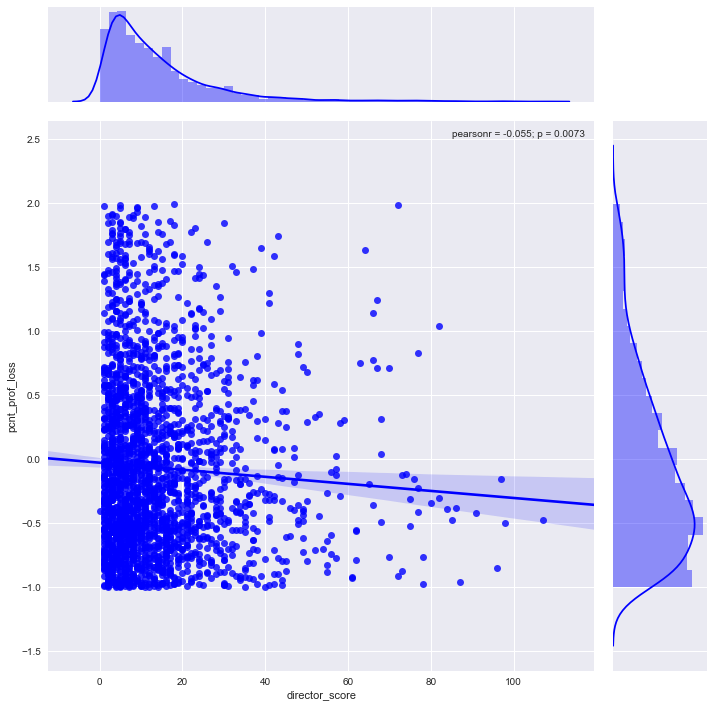

In [162]:
sns.jointplot(temp_df['director_score'], temp_df['pcnt_prof_loss'],  kind="reg", color="b", size=10)
plt.show()

In [629]:
movies_df['pcnt_prof_loss'].describe()

count    2587.000000
mean        1.885869
std        51.065589
min        -0.999928
25%        -0.562242
50%        -0.143890
75%         0.527570
max      2210.449533
Name: pcnt_prof_loss, dtype: float64

In [632]:
movies_df[(movies_df['pcnt_prof_loss']>5)][['title','movieBudget','movie_4th_wknd_bo']]

,title,movieBudget,movie_4th_wknd_bo
49,"Brothers McMullen, The (1995)",25000,4656069.0
74,Clerks (1994),27575,624630.0
212,Around the World in 80 Days (1956),6000000,42000000.0
224,Swingers (1996),200000,3121408.0
240,Raiders of the Lost Ark (Indiana Jones and the...,18000000,181718672.0
277,Jaws (1975),8000000,49516476.0
321,Air Bud (1997),3000000,20249873.0
335,Chasing Amy (1997),250000,3886506.0
403,Pi (1998),60000,601702.0
409,"Breakfast Club, The (1985)",1000000,19149143.0


In [489]:
#------------------------------------------------------------------
    
    
def fix_title_string(title):
    title=title[:title.find('(')].replace(' ','')
    title=title.replace('.','')
    title=title.replace("'",'')
    title=title.replace('-','')
    comma_found=False
    
    #check if there is comma 
    if title.find(',')>0:
        comma_found=True
    
    #Check for The occuring at the end and fix
    if comma_found:
        word_after_comma=title[title.find(','):]
        #check for the word 'The'
        if (word_after_comma.find('The')>0):
            title = title[:title.find(',')]
        #check for 'A'
        if (word_after_comma.find('A')>0):
            title='A'+title[:title.find(',')]
    return title


#------------------------------------------------------------------
  
def get_movie_4thWkndBo_BoMojo(m_title):
    '''
    This function 
    * gets the movie title string that contins the title and the year
    e.g. Frozen (2013)
    * gets the gross-to-date 4th weekend box office collection from
    boxofficemojo website
    * gets the release year from the boxofficemojo site
    * compares the year from the title and the year from the site
    returns 3 items
    1. a flag that says if both the years matches or not
    2. the box office value if found
    3. the release year from boxofficemojo site
    
    the reason why this comparison is done is to check if the box office
    collection was found for the correct movie. the site does have any 
    unique id by which the movie can be idenfied. there are movies that have
    the same name but released in multiple years, e.g. Frozen, there is one
    in 2010 and the big one in 2013
    
    '''
    
    urlpre='http://www.boxofficemojo.com/movies/?page=weekend&id='
    upd_title=fix_title_string(m_title)
    urlfull=urlpre+upd_title+'.htm'
    
    #get the year from the title passed
    year_str=m_title[m_title.find('(')+1:-1].replace(' ','')
    print('year from title :',year_str)

    print(urlfull)
    #get the page to the weekend collection chart
    try:
        url = urllib.request.urlopen(urlfull)
        page = url.read()
    except:
        return('YearNoMatch|'+'Not Found. URL:'+urlfull+'|0')


    #read it into bs4
    soup = BeautifulSoup(page, 'html.parser')

    #navigate to the table that shows the box-office chart
    #the charts are by years
    bochart=soup.findAll("table",{'chart-wide'})

    #to get the box office collection for the fourth weekend
    #get the rows of the first chart
    if len(bochart)>0:
        #valid movie title
        rows=bochart[0].findAll('tr')
    else:
        return('YearNoMatch|'+'Not Found. URL:'+urlfull+'|0')

    #check if the table has atleast 4 rows excluding header
    #this is needed in case of movies released during the
    #last weeks of a year, in which case, it will have only
    #1 or 2 rows
    rows_in_first_chart = len(rows)

    if rows_in_first_chart>4:
        # the first table has at least 4 weekend data
        fourth_wknd_row = rows[4]
    else:
        # the first table has less than 4 weekend data
        if len(bochart)>1:
            rows=bochart[1].findAll('tr')
            if len(rows)> (5-rows_in_first_chart):
                fourth_wknd_row = rows[5-rows_in_first_chart]
            else:
                #these are movies that do not have box-office data
                #for more than 3 weekends, e.g. Sudden Death 
                #(unbelievable, that was an awesome movie!!) 
                return('YearNoMatch|'+'Not Found. URL:'+urlfull+'|0')
        else:
            return('YearNoMatch|'+'Not Found. URL:'+urlfull+'|0')

    #the box office value is present in the 8th column
    wknd_bo_coln = fourth_wknd_row.findAll('td')[7].text
    if wknd_bo_coln is not None:
        #strip the $ and , from the text e.g. from $2,333,443
        wknd_bo_coln = wknd_bo_coln.replace('(Estimate)','')
        wknd_bo_coln = wknd_bo_coln.replace('$','')
        wknd_bo_coln = wknd_bo_coln.replace(',','')

    #get the year from box office mojo website
    urlpre_year='http://www.boxofficemojo.com/movies/?page=main&id='
    urlfull=urlpre_year+upd_title+'.htm'
    #get the page to the weekend collection chart
    try:
        url = urllib.request.urlopen(urlfull)
        page = url.read()
    except:
        return('YearNoMatch|'+wknd_bo_coln+'|0')

    #read it into bs4
    soup = BeautifulSoup(page, 'html.parser')

    #find all td elements, one of them hold the release date
    tds=soup.findAll("td")

    for td in tds:
        pos=td.text.find('Release Date:')
        if pos > 0:
            #pos=td.text.find('Release Date:')
            text=td.text[pos+13:]
            #print('****\n',td.text)
            year_from_bom= text[text.find(',')+2:text.find(',')+6]
            try:
                year_title=int(year_str)
                year_bom=int(year_from_bom)
                if year_title==year_bom:
                    return('YearMatch|'+wknd_bo_coln+'|'+year_from_bom)
                else:
                    return('YearNoMatch|'+wknd_bo_coln+'|'+year_from_bom)
            except:
                return('YearNoMatch|'+wknd_bo_coln+'|'+year_from_bom)
    
    #if there are no td that contain Release Date
    return('YearNoMatch|'+wknd_bo_coln+'|0')


#------------------------------------------------------------------
    
    
